In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import ssl
import pandas as pd
import numpy as np

In [5]:
data = pd.read_csv("./drive/MyDrive/Colab Notebooks/cleanIMDB.csv")

## Models


In [11]:
from keras.preprocessing.text import Tokenizer

# Assuming 'data.review' contains your text data
tokenizer = Tokenizer(num_words=5000)  # This will keep only the 5000 most frequent words
tokenizer.fit_on_texts(data['review'])

X = tokenizer.texts_to_sequences(data['review'])


In [12]:
from keras.preprocessing.sequence import pad_sequences

max_review_length = 500  # Define the maximum length of the reviews
X_padded = pad_sequences(X, maxlen=max_review_length)


In [13]:
from sklearn.model_selection import train_test_split

y = data['sentiment']  # Assuming 'sentiment' column contains your labels
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


### Transformer

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras import layers

In [35]:
def positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_enc[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    return pos_enc


In [34]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [36]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network
max_review_length = 500
inputs = layers.Input(shape=(max_review_length,))
x = Embedding(input_dim=5000, output_dim=embed_dim)(inputs)
x *= tf.math.sqrt(tf.cast(embed_dim, tf.float32))
x += positional_encoding(max_review_length, embed_dim)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_transformer = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model_transformer.fit(X_train_padded, y_train, batch_size=32, epochs=20, validation_split=0.1)


Epoch 1/20
1125/1125 [==============================] - 82s 70ms/step - loss: 0.3866 - accuracy: 0.8083 - val_loss: 0.2748 - val_accuracy: 0.8857
Epoch 2/20
1125/1125 [==============================] - 29s 26ms/step - loss: 0.2516 - accuracy: 0.9013 - val_loss: 0.2975 - val_accuracy: 0.8808
Epoch 3/20
1125/1125 [==============================] - 26s 23ms/step - loss: 0.2279 - accuracy: 0.9106 - val_loss: 0.2848 - val_accuracy: 0.8827
Epoch 4/20
1125/1125 [==============================] - 21s 19ms/step - loss: 0.2177 - accuracy: 0.9166 - val_loss: 0.2927 - val_accuracy: 0.8845
Epoch 5/20
1125/1125 [==============================] - 22s 19ms/step - loss: 0.2082 - accuracy: 0.9182 - val_loss: 0.3100 - val_accuracy: 0.8715
Epoch 6/20
1125/1125 [==============================] - 21s 19ms/step - loss: 0.1933 - accuracy: 0.9230 - val_loss: 0.2973 - val_accuracy: 0.8800
Epoch 7/20
1125/1125 [==============================] - 20s 17ms/step - loss: 0.1766 - accuracy: 0.9270 - val_loss: 0.3747 -

In [37]:
model_transformer.save('./drive/MyDrive/Colab Notebooks/Transformer.h5')

In [30]:
model_transformer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 tf.math.multiply_1 (TFOpLa  (None, 500, 32)           0         
 mbda)                                                           
                                                                 
 tf.math.add_1 (TFOpLambda)  (None, 500, 32)           0         
                                                                 
 transformer_block_1 (Trans  (None, 500, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 32)                0   

In [38]:
import numpy as np
# Predictions for the training set
y_train_pred = model_transformer.predict(X_train_padded)
y_train_pred = (y_train_pred > 0.5)  # Converting probabilities to binary

# Predictions for the testing set
y_test_pred = model_transformer.predict(X_test_padded)
y_test_pred = (y_test_pred > 0.5)

from sklearn.metrics import classification_report

# Assuming y_train and y_test contain the true labels for the training and testing sets respectively
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))


313/313 [==============================] - 2s 7ms/step
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     20039
           1       0.98      0.92      0.95     19961

    accuracy                           0.95     40000
   macro avg       0.95      0.95      0.95     40000
weighted avg       0.95      0.95      0.95     40000

Classification Report for Testing Set:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4961
           1       0.89      0.82      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



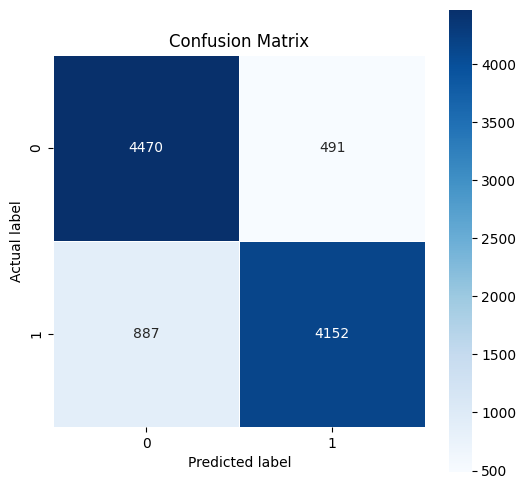

In [40]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)

def plot_roc_curve(y_true, y_scores, set_name="Set"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {set_name}')
    plt.legend(loc="lower right")
    plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, title="Confusion Matrix")

In [41]:
plot_roc_curve(y_test, y_test_pred, set_name="Test")

NameError: ignored